In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import read_quote      as rq
import stock_functions as sf
import df_visualizations as dv
import remap_values as rv

import random
import pickle

import sys
import time

In [2]:
from sklearn.svm            import SVR
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble       import BaggingRegressor
from sklearn.ensemble       import AdaBoostRegressor

from sklearn.utils          import shuffle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.multioutput    import MultiOutputRegressor

In [3]:
%matplotlib inline
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14, 10)

In [4]:
roll_nums = [5,15]#[3,5,7,10,12,15,18,20,22,25,28,30] # Generate an algorithm for predicting every few days
mom_nums  = [3,5,10,20,30]                     # Momentum has many good tracers
rsi_nums  = [10,15]                            # Good for some long term trends
band_nums = [5,10,15,20,25]                    # A few trace different areas well

In [5]:
inpFileList = ['aapl','acm' ,'awk' ,'amzn','awr' ,'ba'  ,'bac' ,'c'   ,'cat' ,'cop' ,'cvx' ,'dal' ,
               'dd'  ,'farm','fdp' ,'gnc' ,'hes' ,'ibm' ,'mas' ,'mcd' ,'mon' ,'msex','msft','nflx',
               'sbux','strl','tgt' ,'tsla','ups' ,'xom' ,'xpo' ,'vmc' ]

In [6]:
scaled_df = sf.get_scaled_data( inpFileList, roll_nums, mom_nums, rsi_nums, band_nums )

In [7]:
# Read in each stock, and perform reduction
#    Break into train, test sets
#    Store train, test sets in arrays
# For each regressor predicting a certain num of days...
#    Manually cross validate, testing and scoring each set

In [8]:
# Mix up the list
shuff_scaled_df = shuffle( scaled_df, random_state=0 )

n_elements = shuff_scaled_df.shape[0]

# Set the fraction of data we will train over
percent_train = 0.7

# Size of training set
n_train = int( percent_train * n_elements )

train_df = shuff_scaled_df[ :  n_train   ]
test_df  = shuff_scaled_df[    n_train : ]

In [9]:
train_x = train_df.dropna().drop( ['close','close_mean_5','close_mean_15'],axis=1 ).values
test_x  =  test_df.dropna().drop( ['close','close_mean_5','close_mean_15'],axis=1 ).values

train_y = train_df.dropna()['close_mean_15'].values
test_y  =  test_df.dropna()['close_mean_15'].values

In [38]:
# 0.427, a=1e-2, hls=100,50,50

params = { 
            'hidden_layer_sizes' : [(100,50,50,),(100,100,100,),(100,50,100,),(100,100,50,),(50,50,50,50,)],
            'alpha'              : [5e-3,1e-2,5e-2],
            'activation'         : ['relu','logistic','tanh']
         }

nn_reg = GridSearchCV( MLPRegressor( random_state=53 ), param_grid=params, cv=3 )
nn_reg.fit( train_x, train_y )
print nn_reg.best_score_
print nn_reg.best_params_

In [40]:
# 0.465, mf=None, mss=2, n_e=70, md=None, pretty much all defaults
# 0.461, n_e = 100

In [63]:
#params = { 
#            'n_estimators'      : [70]
#         }

#rf_reg = GridSearchCV( RandomForestRegressor(), param_grid=params, cv=3 )

# n_estimators=70 - 0.460

rf_reg = RandomForestRegressor( n_estimators=70 )

rf_reg.fit( train_x, train_y )
#print rf_reg.best_score_
#print rf_reg.best_params_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=70, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [42]:
# 0.421, k=rbf, c=1, g=1e-3
# 0.

params = {  
            'kernel':['rbf'],
            'C' : [1e-1,1e0,5e0],
            'gamma': [5e-4,1e-3,1e-2]
         }

sv_reg = GridSearchCV( SVR(), param_grid=params, cv=2 )
sv_reg.fit( train_x, train_y )
print sv_reg.best_score_
print sv_reg.best_params_

In [44]:
# 0.464, mf=0.8, ms=1.0, n_e=50
# 0.455, mf=0.9, ms=1.0, RFR

In [64]:
#params = { 
#            'base_estimator' : [RandomForestRegressor( n_estimators=20 )],
#            'max_features'   : [0.9,0.8,0.7,0.6]
#         }

#ba_reg = GridSearchCV( BaggingRegressor( random_state=53 ), param_grid=params, cv=3 )

# mf=0.8 be=RFR - 0.455

ba_reg = BaggingRegressor( base_estimator=RandomForestRegressor( n_estimators=50 ), max_features=0.8 )

ba_reg.fit( train_x, train_y )
#print ba_reg.best_score_
#print ba_reg.best_params_

BaggingRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=0.8,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

params = { 
            'base_estimator' : [SVR( kernel='rbf', C=5, gamma=1e-2     )],
            'max_features'   : [1.0,0.8,0.6],
            'max_samples'    : [1.0,0.8,0.6]
         }

bs_reg = GridSearchCV( BaggingRegressor( random_state=53 ), param_grid=params, cv=3 )
bs_reg.fit( train_x, train_y )
print bs_reg.best_score_
print bs_reg.best_params_

In [48]:
# 0.488, n_estimators=50, loss=square

In [66]:
#params = { 
#            'loss'           : ['exponential','square']
#         }

#ad_reg = GridSearchCV( AdaBoostRegressor( base_estimator=RandomForestRegressor( n_estimators=10 ), random_state=53 ), 
#                       param_grid=params, cv=3 )

# loss=square - 0.488

ad_reg = AdaBoostRegressor( base_estimator=RandomForestRegressor( n_estimators=20 ), loss='square', n_estimators=100 )

ad_reg.fit( train_x, train_y )
#print ad_reg.best_score_
#print ad_reg.best_params_

AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
         learning_rate=1.0, loss='square', n_estimators=100,
         random_state=None)

In [67]:
from sklearn.metrics import mean_squared_error

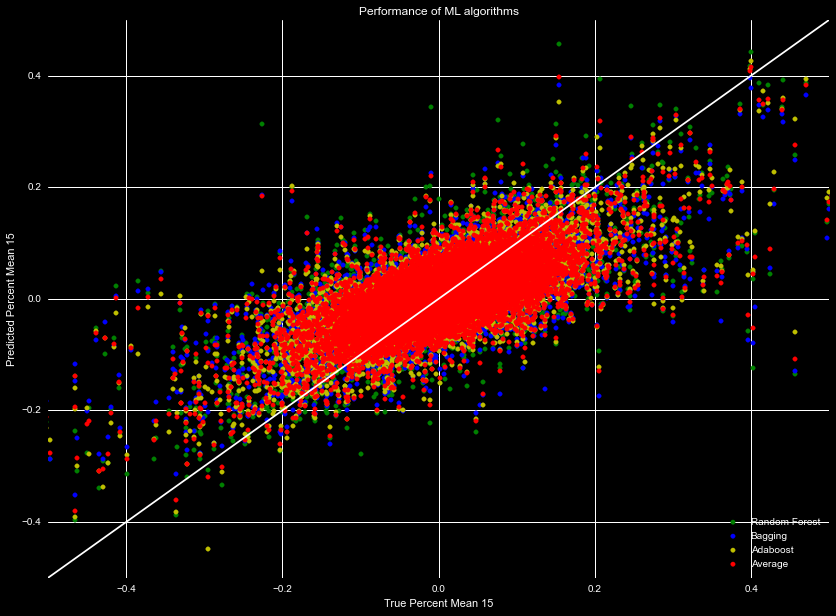

In [68]:
# Plot the data
#nn_y = nn_reg.predict( test_x )
rf_y = rf_reg.predict( test_x )
ba_y = ba_reg.predict( test_x )
#sv_y = sv_reg.predict( test_x )
ad_y = ad_reg.predict( test_x )

avg  = ( rf_y + ba_y + ad_y )/3.0


#plt.scatter( test_y,  sv_y, color='c', label='Support Vector' )
#plt.scatter( test_y,  nn_y, color='r', label='Neural Network' )
plt.scatter( test_y,  rf_y, color='g', label='Random Forest'  )
plt.scatter( test_y,  ba_y, color='b', label='Bagging'        )
plt.scatter( test_y,  ad_y, color='y', label='Adaboost'       )
plt.scatter( test_y,   avg, color='r', label='Average'        )

low =-0.5
hi  = 0.5

plt.plot( [low,hi], [low,hi], color='w' )

plt.legend( loc=4 )
plt.xlim(low,hi)
plt.ylim(low,hi)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('True Percent Mean 15')
plt.ylabel('Predicted Percent Mean 15')
plt.title('Performance of ML algorithms')
plt.show()

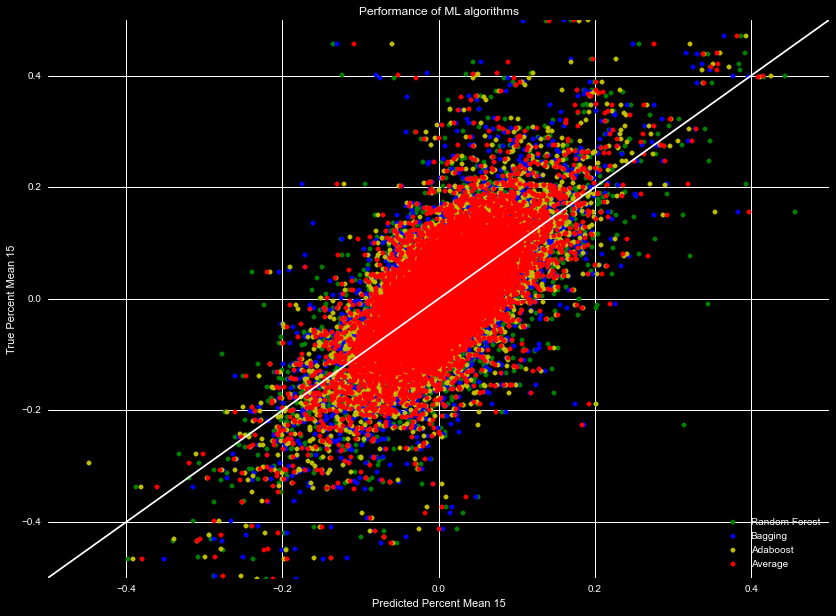

In [69]:
# Plot the data
#nn_y = nn_reg.predict( test_x )
#rf_y = rf_reg.predict( test_x )
#ba_y = ba_reg.predict( test_x )
#sv_y = sv_reg.predict( test_x )
#ad_y = ad_reg.predict( test_x )

#avg  = ( nn_y + rf_y + ba_y + sv_y + ad_y )/5.0


#plt.scatter( sv_y, test_y, color='c', label='Support Vector' )
#plt.scatter( nn_y, test_y, color='r', label='Neural Network' )
plt.scatter( rf_y, test_y, color='g', label='Random Forest'  )
plt.scatter( ba_y, test_y, color='b', label='Bagging'        )
plt.scatter( ad_y, test_y, color='y', label='Adaboost'       )
plt.scatter(  avg, test_y, color='r', label='Average'        )

low =-0.5
hi  = 0.5

plt.plot( [low,hi], [low,hi], color='w' )

plt.legend( loc=4 )
plt.xlim(low,hi)
plt.ylim(low,hi)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Predicted Percent Mean 15')
plt.ylabel('True Percent Mean 15')
plt.title('Performance of ML algorithms')
plt.show()

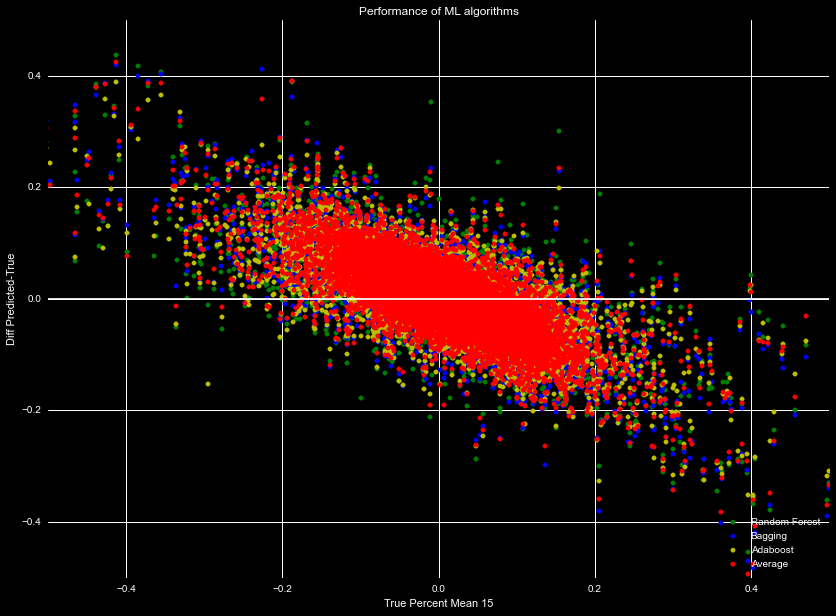

In [70]:
# Plot the data
#nn_y = nn_reg.predict( test_x )
#rf_y = rf_reg.predict( test_x )
#ba_y = ba_reg.predict( test_x )
#sv_y = sv_reg.predict( test_x )
#ad_y = ad_reg.predict( test_x )

avg  = ( nn_y + rf_y + ba_y + sv_y + ad_y )/5.0


#plt.scatter( test_y,  sv_y-test_y, color='c', label='Support Vector' )
#plt.scatter( test_y,  nn_y-test_y, color='r', label='Neural Network' )
plt.scatter( test_y,  rf_y-test_y, color='g', label='Random Forest'  )
plt.scatter( test_y,  ba_y-test_y, color='b', label='Bagging'        )
plt.scatter( test_y,  ad_y-test_y, color='y', label='Adaboost'       )
plt.scatter( test_y,   avg-test_y, color='r', label='Average'        )

low =-0.5
hi  = 0.5

plt.plot( [low,hi], [0,0], color='w' )

plt.legend( loc=4 )
plt.xlim(low,hi)
plt.ylim(-0.5,0.5)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('True Percent Mean 15')
plt.ylabel('Diff Predicted-True')
plt.title('Performance of ML algorithms')
plt.show()

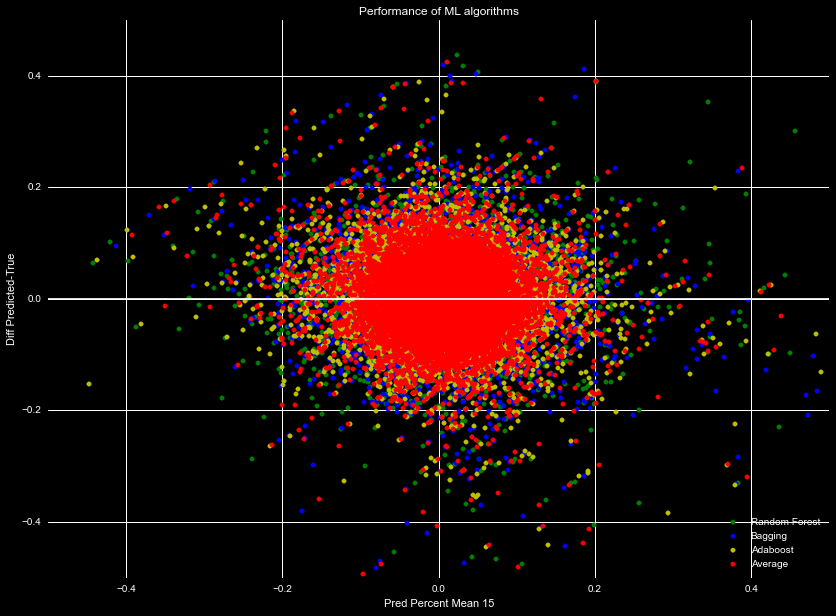

In [71]:
# Plot the data
#nn_y = nn_reg.predict( test_x )
#rf_y = rf_reg.predict( test_x )
#ba_y = ba_reg.predict( test_x )
#sv_y = sv_reg.predict( test_x )
#ad_y = ad_reg.predict( test_x )

avg  = ( nn_y + rf_y + ba_y + sv_y + ad_y )/5.0


#plt.scatter( sv_y,  sv_y-test_y, color='c', label='Support Vector' )
#plt.scatter( nn_y,  nn_y-test_y, color='r', label='Neural Network' )
plt.scatter( rf_y,  rf_y-test_y, color='g', label='Random Forest'  )
plt.scatter( ba_y,  ba_y-test_y, color='b', label='Bagging'        )
plt.scatter( ad_y,  ad_y-test_y, color='y', label='Adaboost'       )
plt.scatter(  avg,   avg-test_y, color='r', label='Average'        )

low =-0.5
hi  = 0.5

plt.plot( [low,hi], [0,0], color='w' )

plt.legend( loc=4 )
plt.xlim(low,hi)
plt.ylim(-0.5,0.5)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Pred Percent Mean 15')
plt.ylabel('Diff Predicted-True')
plt.title('Performance of ML algorithms')
plt.show()

In [73]:
print 'Random Forest MSE: %7.5f' % mean_squared_error( test_y, rf_y )
print 'Bagging       MSE: %7.5f' % mean_squared_error( test_y, ba_y )
print 'Adaboost      MSE: %7.5f' % mean_squared_error( test_y, ad_y )
print 'Averaged      MSE: %7.5f' % mean_squared_error( test_y, avg  )

Random Forest MSE: 0.00273
Bagging       MSE: 0.00277
Adaboost      MSE: 0.00249
Averaged      MSE: 0.00270


In [71]:
plot_frame = pd.DataFrame( {'true':target_values} )
plot_frame['random_forest' ] = rf_reg.predict( variable_values ) - plot_frame['true']
plot_frame['neural_network'] = nn_reg.predict( variable_values ) - plot_frame['true']
plot_frame['bagging'       ] = ba_reg.predict( variable_values ) - plot_frame['true']
plot_frame['average'       ] = (plot_frame['random_forest' ]+
                                plot_frame['bagging'       ]+
                                plot_frame['neural_network'])/3

In [72]:
ll   = 0.5
reg1 = 'random_forest'
reg2 = 'neural_network'
reg3 = 'bagging'
reg4 = 'average'

ax1 = plot_frame.plot(kind='scatter', x='true', y=reg1, color='g', alpha=0.3, label=reg1 )    
ax2 = plot_frame.plot(kind='scatter', x='true', y=reg2, color='r', alpha=0.3, label=reg2, ax=ax1)
ax3 = plot_frame.plot(kind='scatter', x='true', y=reg3, color='b', alpha=0.3, label=reg3, ax=ax1)
ax4 = plot_frame.plot(kind='scatter', x='true', y=reg4, color='k', alpha=0.3, label=reg4, ax=ax1)

#ax1.plot( [-ll,ll], [-ll,ll], color='k' )
ax1.set_ybound( [-ll,ll] )
ax1.set_xlabel( 'True Value' )
ax1.set_ylabel( 'predicted-true' )
ax1.legend( loc=2 )

plt.show()